<a href="https://colab.research.google.com/github/HowonRyu/ConfidenceSet/blob/main/example/Independent_Studies_2023Winter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import sys
import os
import math
import scipy.stats
from tabulate import tabulate

#!rm -rf ConfSets
#!git clone https://github.com/TomMaullin/ConfSets.git
#sys.path.append('/content/ConfSets/lib/')
#from generateData import *
#from boundary import *

!pip install git+https://github.com/HowonRyu/ConfidenceSet.git
from confidenceset.fdr_cope import *
from confidenceset.test import *
from confidenceset.plot import *
from confidenceset.random_field_generator import *
%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HowonRyu/ConfidenceSet.git to /tmp/pip-req-build-mfd72sqj
  Running command git clone --filter=blob:none --quiet https://github.com/HowonRyu/ConfidenceSet.git /tmp/pip-req-build-mfd72sqj
  Resolved https://github.com/HowonRyu/ConfidenceSet.git to commit 6fddd6b49d682b505ec4ea7f257b994130bef931
  Preparing metadata (setup.py) ... done
  Created wheel for confidenceset: filename=confidenceset-0.0.2-py3-none-any.whl size=5466 sha256=9f03082e26b706a426d6f7e9f7b2f088c5f26342643b3b6e7f5237a3247e9069
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qz70vc8/wheels/ca/53/0c/d685b1f54ab8d50428630ab153815b0ac1c2f385a4ebecb60e
Successfully built confidenceset


In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter


def ramp_2D(dim, mag, direction=0, fwhm=0, std=1, truncate=4):
  nsubj = dim[0]

  # signal
  if direction == 0: #vertical
    mu_temp = np.repeat(np.linspace(mag[0], mag[1], dim[2])[::-1],dim[1]).reshape(dim[1],dim[2])
  else: #horizontal
    mu_temp = np.repeat(np.linspace(mag[0], mag[1], dim[2]),dim[1]).reshape(dim[2],dim[1]).transpose()
  mu = np.array(mu_temp, dtype='float')
  #mu = np.tile(mu_temp, nsubj).reshape(dim)


  # noise
  noise = np.random.randn(*dim) * std
  sigma = fwhm / np.sqrt(8 * np.log(2))

  for i in np.arange(nsubj):
    noise[i,:,:] = gaussian_filter(noise[i,:,:], sigma = sigma, truncate=truncate)  #smoothing

  data = np.array(mu + noise, dtype='float')

  return(data, mu)


def circular_2D(dim, shape_spec, truncate=4):
  nsubj = dim[0]
  r = shape_spec['r']
  mag = shape_spec['mag']
  fwhm_noise = shape_spec['fwhm_noise']
  fwhm_signal = shape_spec['fwhm_signal']
  fwhm_signal = shape_spec['fwhm_signal']
  std = shape_spec['std']

  sigma_signal = fwhm_signal / np.sqrt(8 * np.log(2))

  # signal
  x, y = np.meshgrid(np.linspace(-1,1,dim[1]), np.linspace(-1,1,dim[2]))
  cx, cy = 0, 0
  circle = np.array((np.sqrt((x-cx)**2 + (y-cy)**2) <= r), dtype='float')

  sigma_signal = fwhm_signal / np.sqrt(8 * np.log(2))
  circle_smth = gaussian_filter(circle, sigma = sigma_signal, truncate=truncate)
  mu = np.array(circle_smth * mag, dtype='float')

  # noise
  noise = np.random.randn(*dim) * std
  sigma_noise = fwhm_noise / np.sqrt(8 * np.log(2))

  for i in np.arange(nsubj):
    noise[i,:,:] = gaussian_filter(noise[i,:,:], sigma = sigma_noise, truncate=truncate)  #smoothing

  data = np.array(mu + noise, dtype='float')
  return(data, mu)





In [ ]:
def fdr_BH(pvalues, alpha=0.05):
  """
  the Benjamini-Hochberg procedure for false discovery rate control

  Parameters
  ----------
  pvalues : int
    an array or list of p-values
  alpha : int
    [0, 1] alpha level

  Returns
  -------
  rejection_ind : Boolean
    shows whether or not the voxel is rejected
  rejection_locs : int
    locations of the voxels that are rejected (flattened)
  nrejections : int
    number of voxels rejected

  Examples
  --------
  data = numpy.random.randn(100,50,50)
  data_tstat = mvtstat(data - threshold)
  data_dim = data.shape
  nsubj = data_dim[0]
  pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1));
  rejection_ind, _, _ = fdrBH(pvals, alpha)

  :Authors:
    Samuel Davenport <sdavenport@health.ucsd.edu>
    Howon Ryu <howonryu@ucsd.edu>
  """
  pvalues = np.array(pvalues)
  pvals_dim = pvalues.shape
  pvalues_flat = pvalues.flatten()
  sorted_pvalues = np.sort(pvalues_flat)
  sort_index = np.argsort(pvalues_flat)

  m = len(pvalues_flat)
  delta_thres = ((np.arange(m) + 1) / m) * alpha  # threshold collection
  rejection = sorted_pvalues <= delta_thres

  if np.where(rejection)[0].size == 0:
    nrejections = 0
    rejection_locs = None  # flattened or None
    rejection_ind = np.full(np.prod(pvals_dim), 0).reshape(pvals_dim)

  else:
    nrejections = np.where(rejection)[-1][-1] + 1
    rejection_locs = np.sort(sort_index[0:nrejections])  # flattened
    rejection_ind = np.full(np.prod(pvals_dim), 0)
    rejection_ind[rejection_locs] = 1
    rejection_ind = rejection_ind.reshape(pvals_dim)

  return(rejection_ind, rejection_locs, nrejections)


def fdr_cope(data, threshold, method, alpha=0.05, tail="two",
             k=2, alpha0=0.05/4, alpha1=0.05/2):
  """
  sub-setting the confidence set controlling for FDR

  Parameters
  ----------
  data : int
    array of voxels
  threshold : int
    threshold to be used for sub-setting
  alpha : int
    alpha level


  Returns
  -------
  lower_set : array(Boolean)
    voxels in the lower confidence set
  upper_set : array(Boolean)
    voxels in the upper confidence set
  Achat : Boolean
    voxels in the Ac_hat area
  plot_add : array(int)
    area representing lower_set + upper_set + Achat
  n_rej : int or list
    number of voxels rejected by the procedure

  Example
  -------
  nsub = 50
  data = numpy.random.randn(nsub, 100, 100) + 2
  lower, upper = fdr_cope(data, threshold=2, method="BH", alpha=0.05, tail="two)
  plt.imshow(lower)
  plt.imshow(upper)

  nsub = 50
  data = numpy.random.randn(nsub, 100, 100) + 2
  lower, upper = fdr_cope(data, threshold=2, method="AD", alpha0=0.05/4, alpha1 = 0.05/2, k=2 tail="two")
  plt.imshow(lower)
  plt.imshow(upper)

  :Authors:
    Samuel Davenport <sdavenport@health.ucsd.edu>
    Howon Ryu <howonryu@ucsd.edu>
  """
  data_tstat = mvtstat(data - threshold)
  data_dim = data.shape
  nsubj = data_dim[0]
  Achat = data_tstat >= 0
  Achat_C = data_tstat < 0
  n_rej = 0



  if tail == "two":
    pvals = 2 * (1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1))
    rejection_ind = np.full(np.prod(pvals.shape), 0)
    if method == "adaptive":
      rejection_ind, _, n_rej = fdr_adaptive(pvals, k=k, alpha0=alpha0, alpha1=alpha1)
    if method == "BH":
      rejection_ind, _, n_rej = fdrBH(pvals, alpha)
    outer_set = 1 - Achat_C * rejection_ind
    inner_set = Achat * rejection_ind

  if tail == "one":
    inner_pvals = 1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
    outer_pvals = scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
    rejection_ind = np.full(np.prod(inner_pvals.shape), 0)
    if method == "adaptive":
      inner_rejection_ind, _, inner_n_rej = fdr_adaptive(inner_pvals, k=k, alpha0=alpha0, alpha1=alpha1)
      outer_rejection_ind, _, outer_n_rej = fdr_adaptive(outer_pvals, k=k, alpha0=alpha0, alpha1=alpha1)
    if method == "BH":
      inner_rejection_ind, _, inner_n_rej = fdr_BH(inner_pvals, alpha=alpha)
      outer_rejection_ind, _, outer_n_rej = fdr_BH(outer_pvals, alpha=alpha)
    n_rej = [inner_n_rej, outer_n_rej]
    outer_set = 1 - Achat_C * outer_rejection_ind
    inner_set = Achat * inner_rejection_ind

  plot_add = outer_set + inner_set + Achat
  return(outer_set, inner_set, Achat, plot_add, n_rej)



In [ ]:
def conf_plot_agg(c, method, std = 5, tail="two", _min=0, _max=3, fontsize = 25, figsize=(30, 20)):
  dim_100 = (80,100,100)
  spec_cir_l100 = {'r':0.8, 'std':std,'mag':3, 'fwhm_noise':0, 'fwhm_signal':10*2 }
  spec_cir_s100 = {'r':0.45, 'std':std,'mag':3, 'fwhm_noise':0, 'fwhm_signal':10*2 }
  spec_cir_l100_smth = {'r':0.8, 'std':std,'mag':3, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }
  spec_cir_s100_smth = {'r':0.45, 'std':std,'mag':3, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }

  circular_l100 = circular_2D(dim=dim_100, shape_spec=spec_cir_l100)[0]
  circular_s100 = circular_2D(dim=dim_100, shape_spec=spec_cir_s100)[0]
  circular_l100_smth = circular_2D(dim=dim_100, shape_spec=spec_cir_l100_smth)[0]
  circular_s100_smth = circular_2D(dim=dim_100, shape_spec=spec_cir_s100_smth)[0]
  ramp_100 = ramp_2D(dim=dim_100, mag=(0,3), direction=1, fwhm=0, std=std)[0]
  ramp_100_smth = ramp_2D(dim=dim_100, mag=(0,3), direction=1, fwhm=3*2, std=std)[0]

  fig, axs = plt.subplots(2, 4, figsize=figsize)

  im = axs[0, 0].imshow(fdr_cope(data=circular_l100, method=method, threshold=c, tail=tail)[3], vmin=_min, vmax=_max)
  axs[0, 0].set_title("large circle (100*100)", fontsize = fontsize)

  im = axs[0, 1].imshow(fdr_cope(data=circular_s100, method=method, threshold=c, tail=tail)[3], vmin=_min, vmax=_max)
  axs[0, 1].set_title("small circle (100*100)", fontsize = fontsize)

  im = axs[0, 2].imshow(fdr_cope(data=circular_l100_smth, method=method, threshold=c, tail=tail)[3], vmin=_min, vmax=_max)
  axs[0, 2].set_title("large circle (100*100, smoothed noise)", fontsize = fontsize)

  im = axs[0, 3].imshow(fdr_cope(data=circular_s100_smth, method=method, threshold=c, tail=tail)[3], vmin=_min, vmax=_max)
  axs[0, 3].set_title("small circle (100*100, smoothed noise)", fontsize = fontsize)

  im = axs[1, 0].imshow(fdr_cope(data=ramp_100, method=method, threshold=c, tail=tail)[3], vmin=_min, vmax=_max)
  axs[1, 0].set_title("ramp (100*100)", fontsize = fontsize)

  im = axs[1, 2].imshow(fdr_cope(data=ramp_100_smth, method=method, threshold=c, tail=tail)[3], vmin=_min, vmax=_max)
  axs[1, 2].set_title("ramp (100*100, smoothed noise)", fontsize = fontsize)

  axs[1, 1].text(0.5, 0.5, s='',
               fontsize = 20,horizontalalignment='center',
     verticalalignment='center')
  axs[1, 1].set_axis_off()
  axs[1, 3].text(0.5, 0.5, s='',
               fontsize = 20,horizontalalignment='center',
     verticalalignment='center')
  axs[1, 3].set_axis_off()

  cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.5])
  fig.colorbar(im, cax=cbar_ax)

  plt.show()

# FDR Confidence Set



\begin{array}{|c|c|} \hline
 & N & P &  \\ \hline
H_0 & TN & FP & m_0 \\
H_1 & FN & TP & m-m_0 \\ \hline
 & m-R & R & m \\ \hline
\end{array}


**Family Wise Error Rate (FWER)**
*   $FWER = P(FP \ge 1 | H_0)$
*   In multiple testing, use Bonferroni to control for: $FWER <\frac{\alpha}{m}$



**False Discovery Rate (FDR)**

*   $FDR = E(\frac{FP}{R} | R>0)P(R>0) = E \frac{FP}{\max(1,R)} $
*  ((If you can add BH proof))

## Signals

Different settings of image size and variance

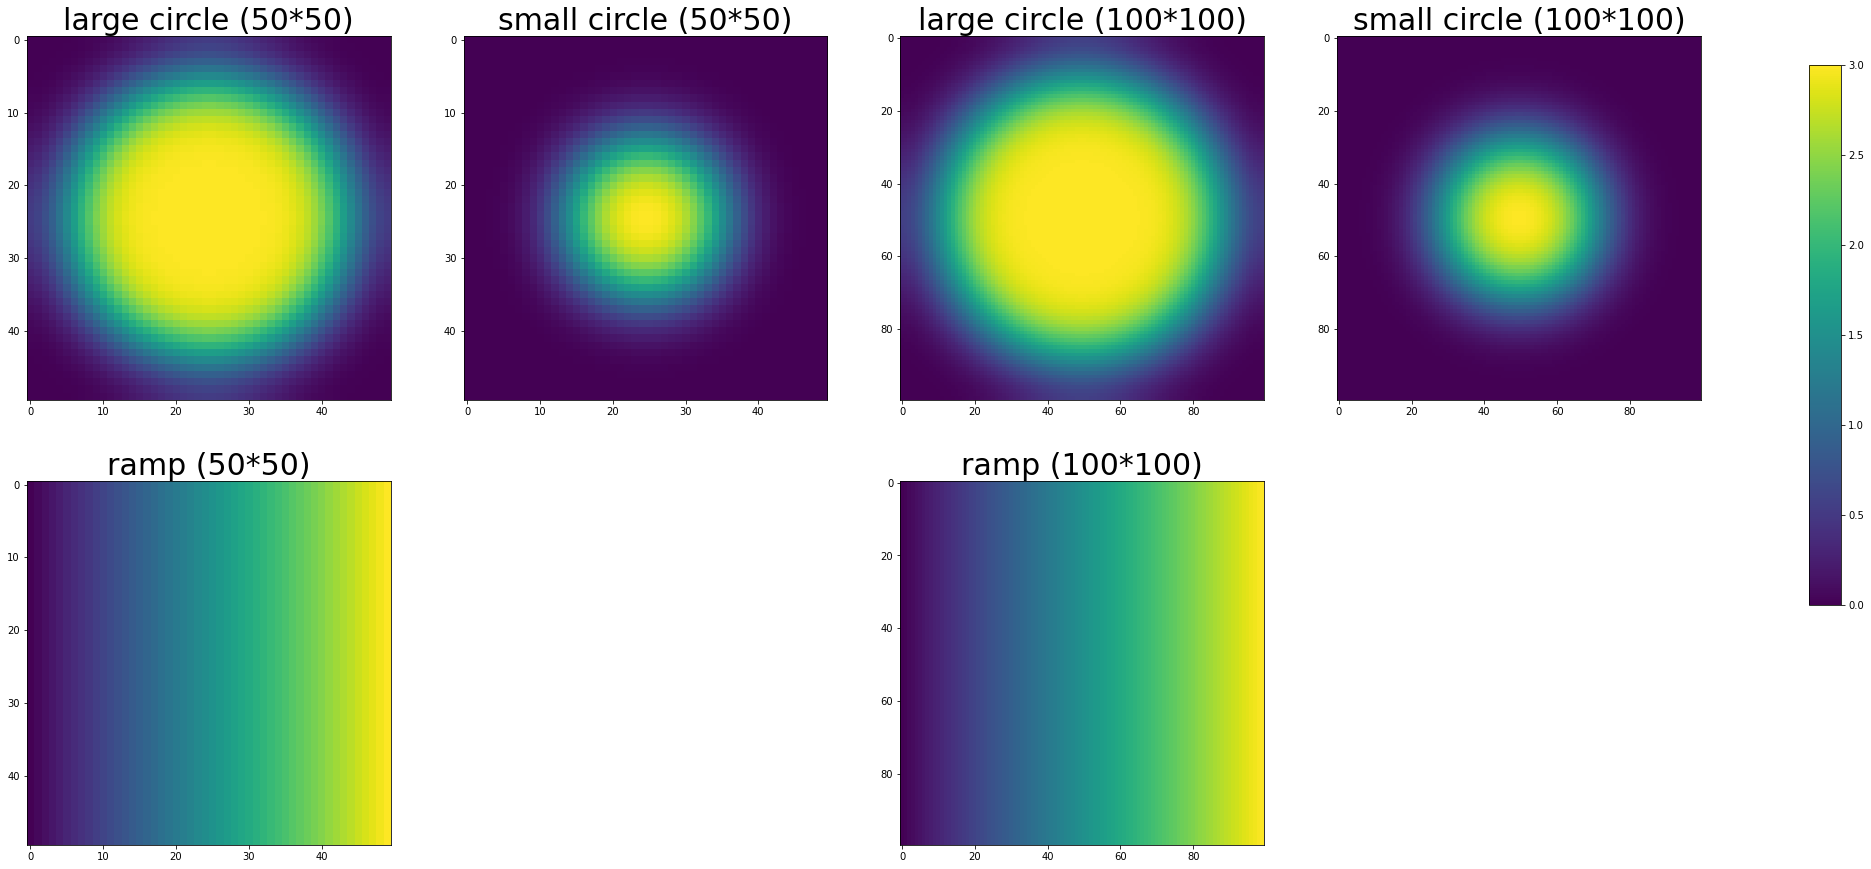

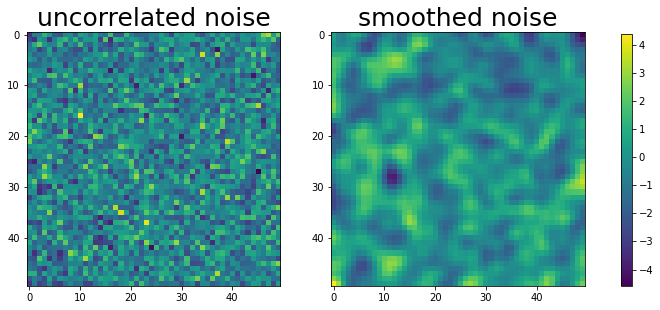

In [ ]:
dim_100 = (80,100,100)
dim_50 = (80, 50, 50)
std = 5
mag = 3

spec_cir_l50 = {'r':0.8, 'std':std, 'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10 }
spec_cir_s50 = {'r':0.45, 'std':std, 'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10 }
spec_cir_l100 = {'r':0.8, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10*2 }
spec_cir_s100 = {'r':0.45, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10*2 }
spec_cir_l50_smth = {'r':0.8, 'std':std,'mag':mag, 'fwhm_noise':3, 'fwhm_signal':10 }
spec_cir_s50_smth = {'r':0.45, 'std':std,'mag':mag, 'fwhm_noise':3, 'fwhm_signal':10 }
spec_cir_l100_smth = {'r':0.8, 'std':std,'mag':mag, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }
spec_cir_s100_smth = {'r':0.45, 'std':std,'mag':mag, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }

#circular
circular_l, mu_circular_l = circular_2D(dim=dim_50, shape_spec=spec_cir_l50)
circular_s, mu_circular_s = circular_2D(dim=dim_50, shape_spec=spec_cir_s50)
circular_l100, mu_circular_l100 = circular_2D(dim=dim_100, shape_spec=spec_cir_l100)
circular_s100, mu_circular_s100 = circular_2D(dim=dim_100, shape_spec=spec_cir_s100)
circular_l_smth, mu_circular_l_smth = circular_2D(dim=dim_50, shape_spec=spec_cir_l50_smth)
circular_s_smth, mu_circular_s_smth = circular_2D(dim=dim_50, shape_spec=spec_cir_s50_smth)
circular_l100_smth, mu_circular_l100_smth = circular_2D(dim=dim_100, shape_spec=spec_cir_l100_smth)
circular_s100_smth, mu_circular_s100_smth = circular_2D(dim=dim_100, shape_spec=spec_cir_s100_smth)

#ramp
ramp_50, mu_ramp_50 = ramp_2D(dim=dim_50, mag=(0,mag), direction=1, fwhm=0, std=std)
ramp_50_smth, mu_ramp_50_smth = ramp_2D(dim=dim_50, mag=(0,mag), direction=1, fwhm=3, std=std)
ramp_100, mu_ramp_100 = ramp_2D(dim=dim_100, mag=(0,mag), direction=1, fwhm=0, std=5)
ramp_100_smth, mu_ramp_100_smth = ramp_2D(dim=dim_100, mag=(0,mag), direction=1, fwhm=3*2, std=std)


#plotting
fig, axs = plt.subplots(2, 4, figsize=(30, 15))
im = axs[0,0].imshow(mu_circular_l)
axs[0,0].set_title("large circle (50*50)", fontsize = 30)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[0,1].imshow(mu_circular_s)
axs[0,1].set_title("small circle (50*50)", fontsize = 30)
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[0,2].imshow(mu_circular_l100)
axs[0,2].set_title("large circle (100*100)", fontsize = 30)
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[0,3].imshow(mu_circular_s100)
axs[0,3].set_title("small circle (100*100)", fontsize = 30)
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[1,0].imshow(mu_ramp_50)
axs[1,0].set_title("ramp (50*50)", fontsize = 30)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1,2].imshow(mu_ramp_100)
axs[1,2].set_title("ramp (100*100)", fontsize = 30)
#plt.colorbar(im01, ax=axs[0, 1])

axs[1, 1].text(0.5, 0.5, s='',
               fontsize = 20,horizontalalignment='center',
     verticalalignment='center')
axs[1, 1].set_axis_off()
axs[1, 3].text(0.5, 0.5, s='',
               fontsize = 20,horizontalalignment='center',
     verticalalignment='center')
axs[1, 3].set_axis_off()

cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()




fig, axs = plt.subplots(1, 2, figsize=(10, 7))


im = axs[0].imshow(circular_l[0,:,:]-mu_circular_l)
axs[0].set_title("uncorrelated noise", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1].imshow(circular_l_smth[0,:,:]-mu_circular_l_smth)
axs[1].set_title("smoothed noise", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])


cbar_ax = fig.add_axes([0.95, 0.25, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Confidence Set Construction
See how one-sided and two-sided tests and sub-setting for inner and outer confidence sets are constructd

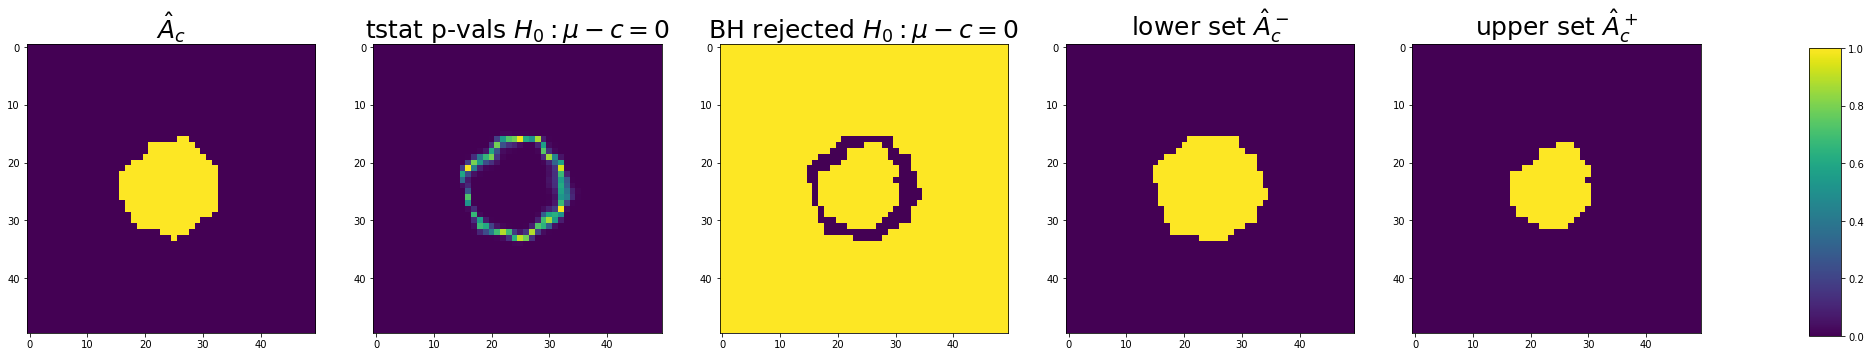

In [ ]:
data = circular_s_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0


# a two sided test
pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
outer_set_2 = 1- Achat_C * rejection_ind
inner_set_2 = Achat*rejection_ind
  


fig, axs = plt.subplots(1, 5, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)
im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c = 0$", fontsize = 25)
im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c = 0$", fontsize = 25)
im = axs[3].imshow(outer_set_2, vmin = _min, vmax = _max)
axs[3].set_title("lower set $\hat{A}_c^-$", fontsize = 25)
im = axs[ 4].imshow(inner_set_2, vmin = _min, vmax = _max)
axs[4].set_title("upper set $\hat{A}_c^+$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()


#    outer_set = 1- Achat_C*outer_rejection_ind = Achat {Union} rejection_ind complement
#    inner_set = Achat*inner_rejection_ind

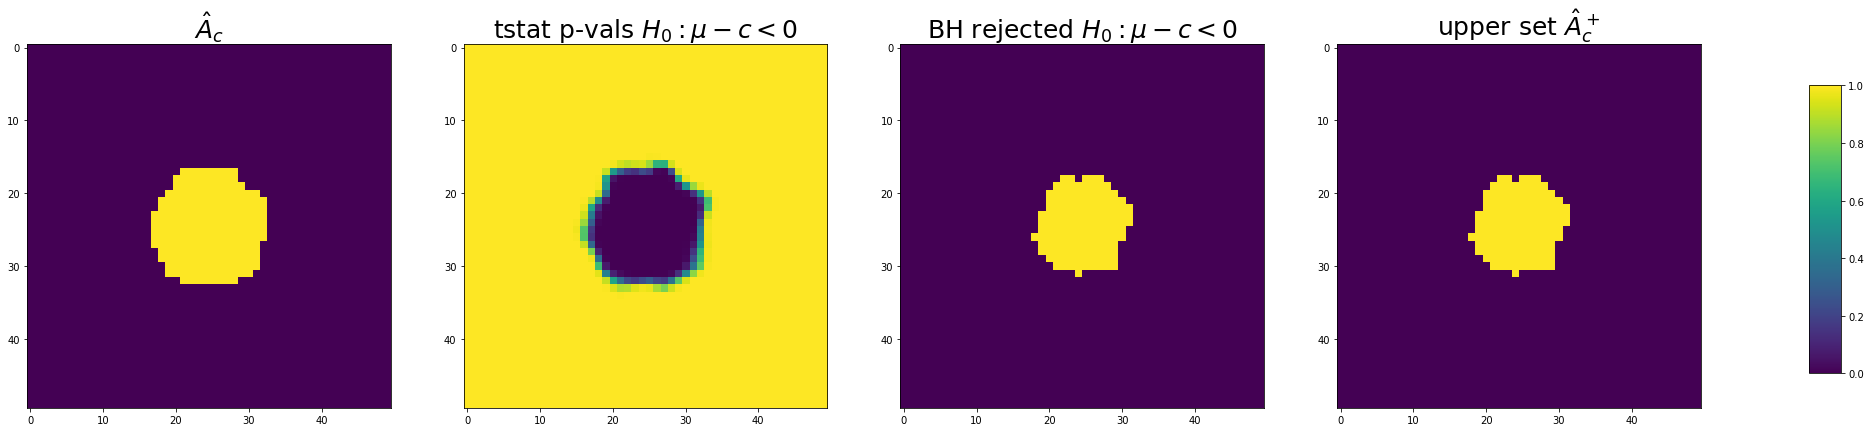

In [ ]:
# one-sided for upper set (H_0: mu < c)
data = circular_s_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0


pvals = (1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
inner_set_1 = Achat*rejection_ind
  


fig, axs = plt.subplots(1, 4, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)

im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c < 0$", fontsize = 25)


im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c < 0$", fontsize = 25)

im = axs[3].imshow(inner_set_1, vmin = _min, vmax = _max)
axs[3].set_title("upper set $\hat{A}_c^+$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()

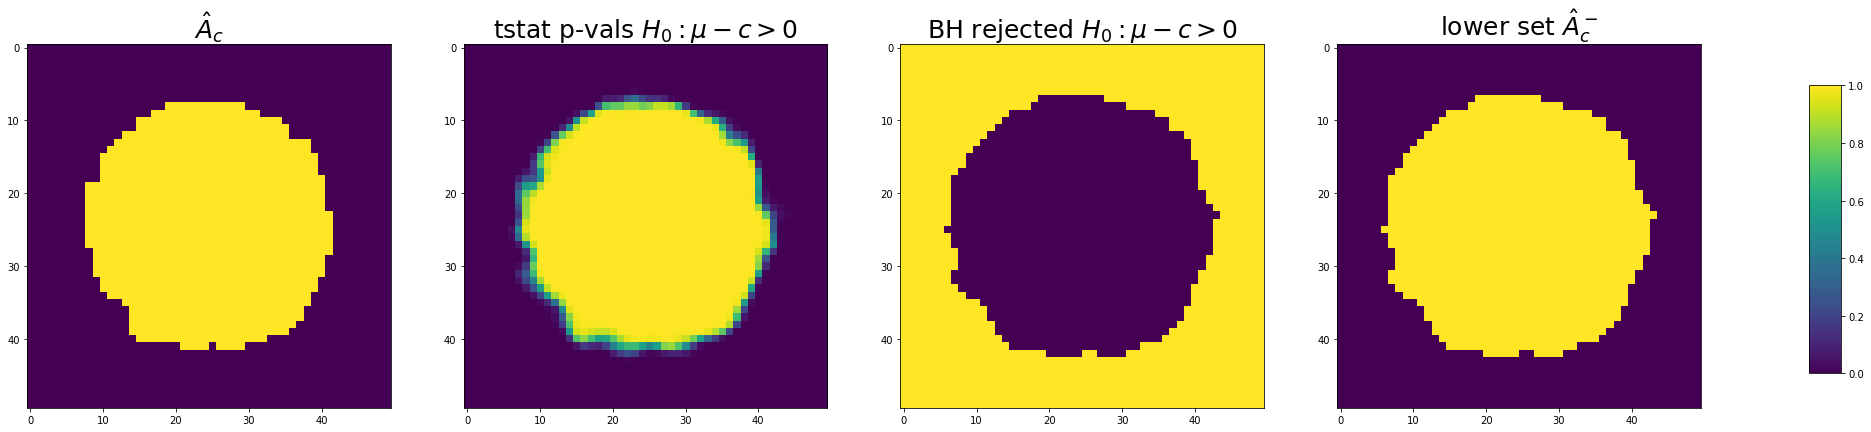

In [ ]:
# one-sided for lower set (H_0: mu > c) 
data = circular_l_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0

pvals = (scipy.stats.t.cdf(data_tstat, df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
outer_set_1 = (1 - Achat_C*rejection_ind) #using Ac- formula

fig, axs = plt.subplots(1, 4, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)

im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c > 0$", fontsize = 25)


im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c > 0$", fontsize = 25)

im = axs[3].imshow(outer_set_1, vmin = _min, vmax = _max)
axs[3].set_title("lower set $\hat{A}_c^-$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()

## Confidence Sets
Now we look at $\hat{A}_c^+ + \hat{A}_c^-$ + $A_c$

### BH

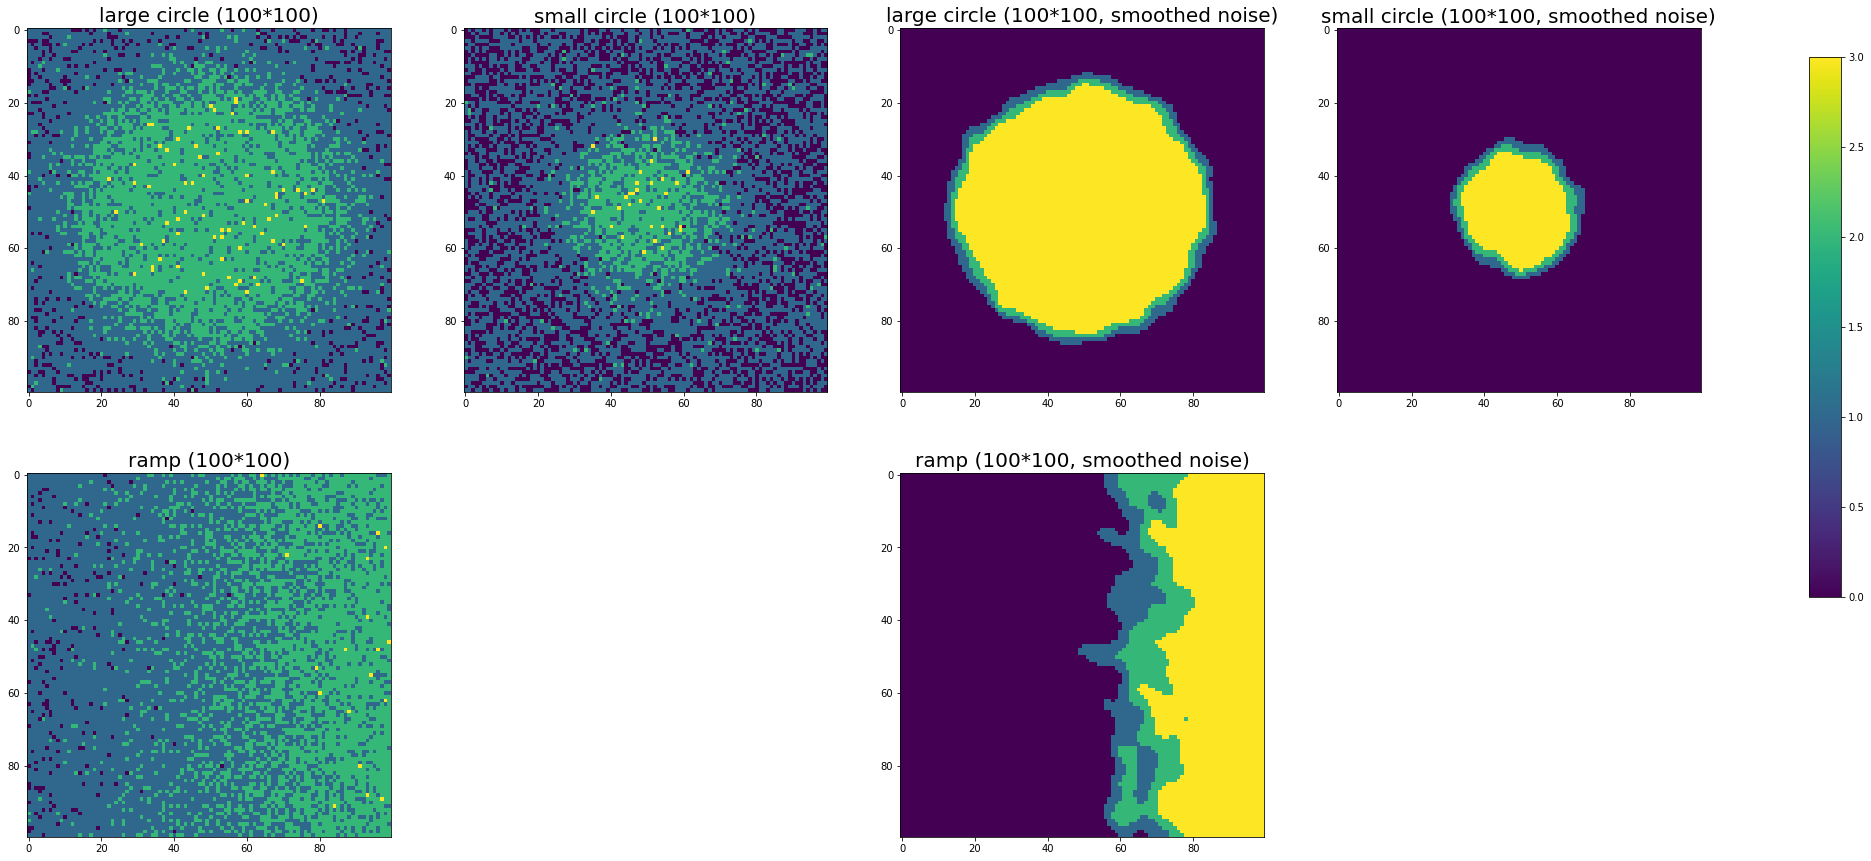

In [ ]:
conf_plot_agg(c=2, std=8, tail="two", method="BH", _min=0, _max=3, fontsize=20, figsize = (30,15))

### Adaptive

*   Used k=2, $\alpha_0 = 0.05/4$, $\alpha_1 = 0.05/2$

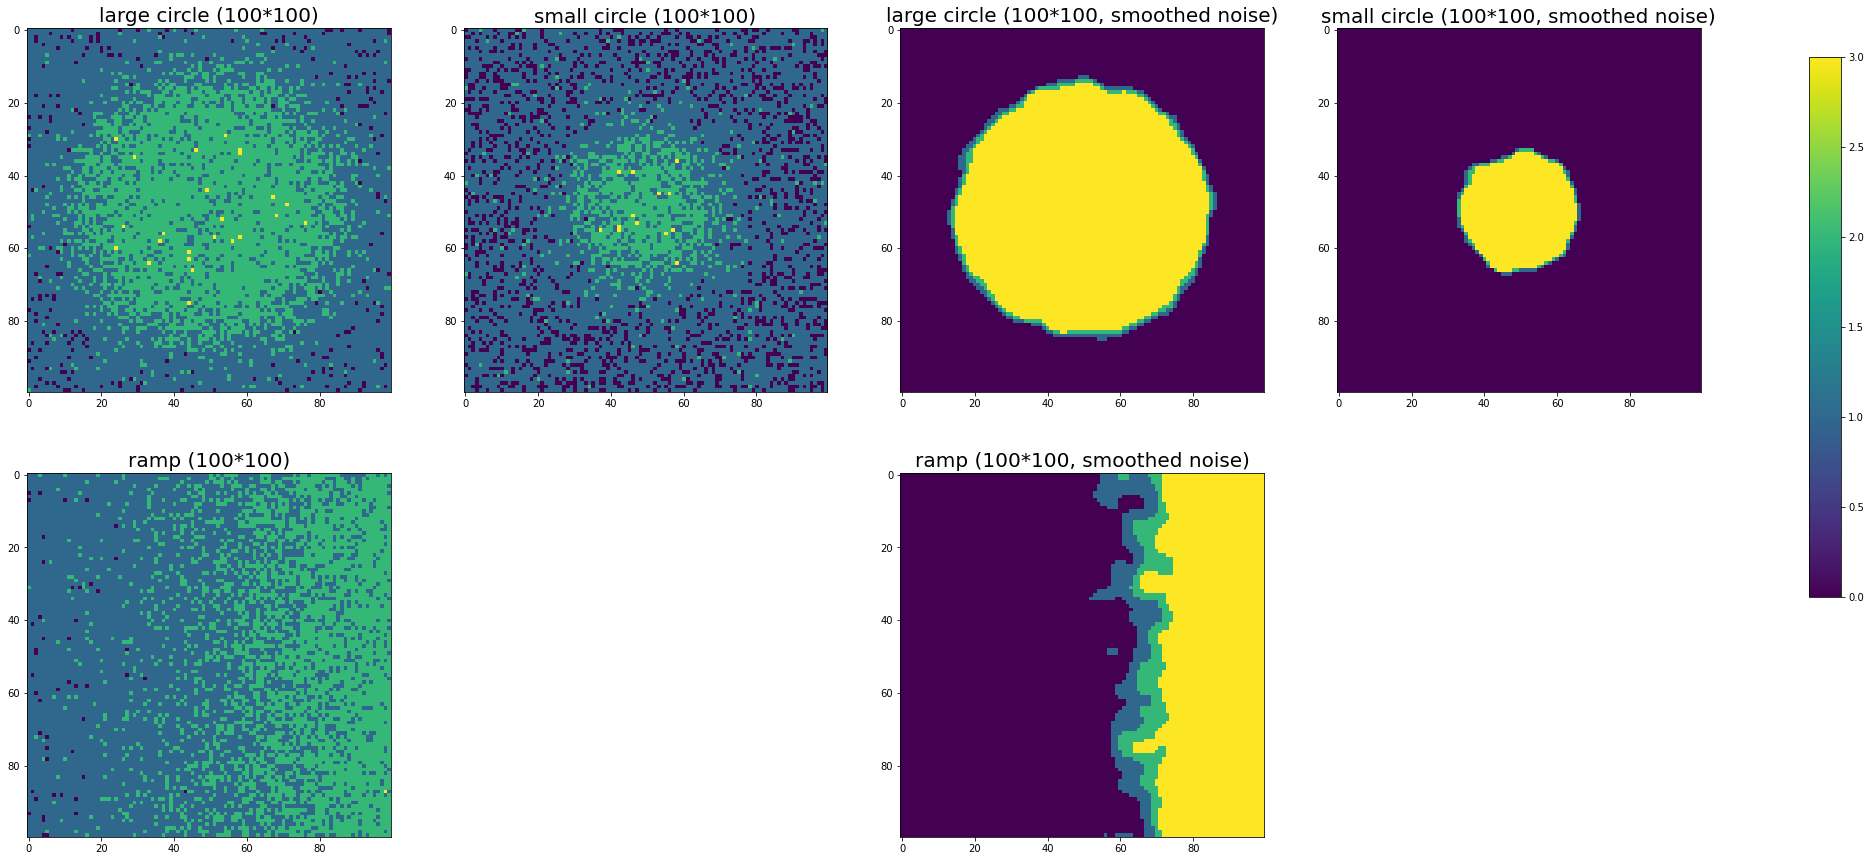

In [ ]:
conf_plot_agg(c=2, std=8, tail="two", method="adaptive", _min=0, _max=3, fontsize=20, figsize = (30,15))

# FDR Simulations

## 1) FDR: $E\frac{| \{\hat{A}_c^+ - A_c\} 𝖴 \{ A_c - \hat{A}_c^-\} |} { | \hat{A}_c^+ 𝖴  \hat{A}_c^{-c} |  }$


In [ ]:
def fdr_error_check(dim, c, shape, method, shape_spec=None, mag=3, direction=1, fwhm=3, 
                    std=5, alpha=0.05, tail="two"):
  if (shape == 'noise'):
    data = np.random.randn(*dim) * std
    mu = np.zeros((dim[1],dim[2]))

  if (shape == "circular"):
    data, mu = circular_2D(dim=dim, shape_spec = shape_spec)
  if (shape == "ramp"):
    data, mu = ramp_2D(dim=dim, std=std, mag=(0,mag), direction=direction, fwhm=fwhm)

  Ac = mu>=c
  AcC = 1-Ac
  lower, upper, Achat, all_sets, n_rej = fdr_cope(data, method = method, threshold=c, alpha=alpha, tail=tail)

  if tail == "one":
    numer = np.sum(np.maximum(upper - Ac.astype(int), 0))
    denom = np.sum(upper)  

  if tail == "two":
    numer = np.sum(np.minimum(np.maximum(upper - Ac.astype(int), 0) + np.maximum(Ac.astype(int) - lower, 0), 1))
    denom = np.sum(np.minimum(upper + (1-lower), 1) )

  if n_rej ==0:
    ERR=0
  else:
    ERR = numer / denom

  return(ERR)

Sanity check: No signal image with c=0 (expecting <0.05 FDR)

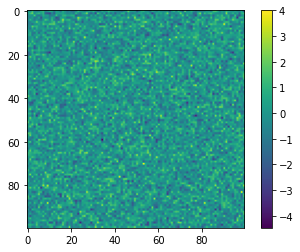

100*100 no signal ERR: 0.03


In [ ]:
no_signal = np.random.randn(*dim_l)
plt.imshow(no_signal[0,:,:])
plt.colorbar()
plt.show()

nosig_ERR1 = []
num_sim=100
for i in np.arange(num_sim):
  nosig_ERR1.append(fdr_error_check(dim=(80,100,100), c=0, method="BH", shape = 'noise', std=3, alpha=0.05, tail="two"))

print("100*100 no signal ERR:", np.mean(nosig_ERR1))


FDR 1,000 simulations

In [ ]:
def fdr_error_check_sim(sim_num, method, c, c_marg=0.2, std=5, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2):
  dim_100 = (80,100,100)
  dimprod_100 = dim_100[1]*dim_100[2]
  dim_50 = (80, 50, 50)
  dimprod_50 = dim_50[1]*dim_50[2]
  up0, lo0 = c[0]+c_marg, c[0]-c_marg
  up1, lo1 = c[1]+c_marg, c[1]-c_marg
  up2, lo2 = c[2]+c_marg, c[2]-c_marg

  #ramps
  mu_ramp_50 = ramp_2D(dim=dim_50, mag=(0,3), direction=1, fwhm=0, std=std)[1]
  mu_ramp_100 = ramp_2D(dim=dim_100, mag=(0,3), direction=1, fwhm=0, std=std)[1]

  m0_ramp_50_c0 = np.sum(np.logical_and(mu_ramp_50 < up0, mu_ramp_50 > lo0))
  m0_ramp_50_c1 = np.sum(np.logical_and(mu_ramp_50 < up1, mu_ramp_50 > lo1))
  m0_ramp_50_c2 = np.sum(np.logical_and(mu_ramp_50 < up2, mu_ramp_50 > lo2))
  m0_ramp_100_c0 = np.sum(np.logical_and(mu_ramp_100 < up0, mu_ramp_100 > lo0))
  m0_ramp_100_c1 = np.sum(np.logical_and(mu_ramp_100 < up1, mu_ramp_100 > lo1))
  m0_ramp_100_c2 = np.sum(np.logical_and(mu_ramp_100 < up2, mu_ramp_100 > lo2))

  #circles
  spec_cir_s50 = {'r':0.45, 'std':std, 'mag':3, 'fwhm_noise':0, 'fwhm_signal':10 }
  spec_cir_s50_smth = {'r':0.45, 'std':std,'mag':3, 'fwhm_noise':3, 'fwhm_signal':10 }
  spec_cir_l50 = {'r':0.8, 'std':std, 'mag':3, 'fwhm_noise':0, 'fwhm_signal':10 }
  spec_cir_l50_smth = {'r':0.8, 'std':std,'mag':3, 'fwhm_noise':3, 'fwhm_signal':10 }

  spec_cir_s100 = {'r':0.45, 'std':std, 'mag':3, 'fwhm_noise':0, 'fwhm_signal':10*2 }
  spec_cir_s100_smth = {'r':0.45, 'std':std,'mag':3, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }
  spec_cir_l100 = {'r':0.8, 'std':std, 'mag':3, 'fwhm_noise':0, 'fwhm_signal':10*2 }
  spec_cir_l100_smth = {'r':0.8, 'std':std,'mag':3, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }

  mu_circular_s50 = circular_2D(dim=dim_50, shape_spec=spec_cir_s50)[1]
  mu_circular_l50 = circular_2D(dim=dim_50, shape_spec=spec_cir_l50)[1]
  m0_small50_c0 = np.sum(np.logical_and(mu_circular_s50 < up0, mu_circular_s50 > lo0))
  m0_small50_c1 = np.sum(np.logical_and(mu_circular_s50 < up1, mu_circular_s50 > lo1))
  m0_small50_c2 = np.sum(np.logical_and(mu_circular_s50 < up2, mu_circular_s50 > lo2))
  m0_large50_c0 = np.sum(np.logical_and(mu_circular_l50 < up0, mu_circular_l50 > lo0))
  m0_large50_c1 = np.sum(np.logical_and(mu_circular_l50 < up1, mu_circular_l50 > lo1))
  m0_large50_c2 = np.sum(np.logical_and(mu_circular_l50 < up2, mu_circular_l50 > lo2))

  mu_circular_s100 = circular_2D(dim=dim_100, shape_spec=spec_cir_s100)[1]
  mu_circular_l100 = circular_2D(dim=dim_100, shape_spec=spec_cir_l100)[1]
  m0_small100_c0 = np.sum(np.logical_and(mu_circular_s100 < up0, mu_circular_s100 > lo0))
  m0_small100_c1 = np.sum(np.logical_and(mu_circular_s100 < up1, mu_circular_s100 > lo1))
  m0_small100_c2 = np.sum(np.logical_and(mu_circular_s100 < up2, mu_circular_s100 > lo2))
  m0_large100_c0 = np.sum(np.logical_and(mu_circular_l100 < up0, mu_circular_l100 > lo0))
  m0_large100_c1 = np.sum(np.logical_and(mu_circular_l100 < up1, mu_circular_l100 > lo1))
  m0_large100_c2 = np.sum(np.logical_and(mu_circular_l100 < up2, mu_circular_l100 > lo2))


  ###################### 50*50 #########################
  #initializing and labeling
  ERR = dict()
  ERR['threshold'] = ["c="+str(c[0]), "c="+str(c[1]), "c="+str(c[2])]

  #small 50*50
  ERR['circle(s)'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR['circle(s)'][0].append(fdr_error_check(dim_50, c=c[0], shape="circular", method=method, shape_spec=spec_cir_s50, alpha=alpha, tail=tail))
    ERR['circle(s)'][1].append(fdr_error_check(dim_50, c=c[1], shape="circular", method=method, shape_spec=spec_cir_s50, alpha=alpha, tail=tail))
    ERR['circle(s)'][2].append(fdr_error_check(dim_50, c=c[2], shape="circular", method=method, shape_spec=spec_cir_s50, alpha=alpha, tail=tail))

  #small_smth 50*50
  ERR['circle(s)smth'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR['circle(s)smth'][0].append(fdr_error_check(dim_50, c=c[0], shape="circular", method=method, shape_spec=spec_cir_s50_smth, alpha=alpha, tail=tail))
    ERR['circle(s)smth'][1].append(fdr_error_check(dim_50, c=c[1], shape="circular", method=method, shape_spec=spec_cir_s50_smth, alpha=alpha, tail=tail))
    ERR['circle(s)smth'][2].append(fdr_error_check(dim_50, c=c[2], shape="circular", method=method, shape_spec=spec_cir_s50_smth, alpha=alpha, tail=tail))

  # m0/m
  ERR['alpha*m0/m(small)'] = [np.round(0.05*m0_small50_c0/(dimprod_50),6), np.round(0.05*m0_small50_c1/(dimprod_50),6), np.round(0.05*m0_small50_c2/(dimprod_50),6)]

  #large 50*50
  ERR['circle(l)'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR['circle(l)'][0].append(fdr_error_check(dim_50, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l50, alpha=alpha, tail=tail))
    ERR['circle(l)'][1].append(fdr_error_check(dim_50, c=c[1], shape="circular", method=method, shape_spec=spec_cir_l50, alpha=alpha, tail=tail))
    ERR['circle(l)'][2].append(fdr_error_check(dim_50, c=c[2], shape="circular", method=method, shape_spec=spec_cir_l50, alpha=alpha, tail=tail))

  #large_smth 50*50
  ERR['circle(l)smth'] = [[],[],[]]

  for i in np.arange(sim_num):
    ERR['circle(l)smth'][0].append(fdr_error_check(dim_50, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l50_smth, alpha=alpha, tail=tail))
    ERR['circle(l)smth'][1].append(fdr_error_check(dim_50, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l50_smth, alpha=alpha, tail=tail))
    ERR['circle(l)smth'][2].append(fdr_error_check(dim_50, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l50_smth, alpha=alpha, tail=tail))
  
  # m0/m
  ERR['alpha*m0/m(large)'] = [np.round(0.05*m0_large50_c0/(dimprod_50),6), np.round(0.05*m0_large50_c1/(dimprod_50),6), np.round(0.05*m0_large50_c2/(dimprod_50),6)]

  # ramp 50*50
  ERR['ramp'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR['ramp'][0].append(fdr_error_check(dim_50, c=c[0], shape="ramp", method=method, mag=3, direction=1, fwhm=0, std=std, alpha=alpha, tail=tail))
    ERR['ramp'][1].append(fdr_error_check(dim_50, c=c[1], shape="ramp", method=method, mag=3, direction=1, fwhm=0, std=std, alpha=alpha, tail=tail))
    ERR['ramp'][2].append(fdr_error_check(dim_50, c=c[2], shape="ramp", method=method, mag=3, direction=1, fwhm=0, std=std, alpha=alpha, tail=tail))

  # ramp_smth 50*50
  ERR['ramp_smth'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR['ramp_smth'][0].append(fdr_error_check(dim_50, c=c[0], shape="ramp", method=method, mag=3, direction=1, fwhm=3, std=std, alpha=alpha, tail=tail))
    ERR['ramp_smth'][1].append(fdr_error_check(dim_50, c=c[1], shape="ramp", method=method, mag=3, direction=1, fwhm=3, std=std, alpha=alpha, tail=tail))
    ERR['ramp_smth'][2].append(fdr_error_check(dim_50, c=c[2], shape="ramp", method=method, mag=3, direction=1, fwhm=3, std=std, alpha=alpha, tail=tail))

  # m0/m
  ERR['alpha*m0/m(ramp)'] = [np.round(0.05*m0_ramp_50_c0/(50*50),6), np.round(0.05*m0_ramp_50_c1/(50*50),6), np.round(0.05*m0_ramp_50_c2/(50*50),6)]


  ERR_key_calc = [list(ERR.keys())[i] for i in [1,2,4,5,7,8]]
  ERR.update({n: np.round(np.nanmean(ERR[n],axis=1),4) for n in ERR_key_calc})

  ###################### 100*100 #########################
  #initializing and labeling
  ERR2 = dict()
  ERR2['threshold'] = ["c="+str(c[0]), "c="+str(c[1]), "c="+str(c[2])]

  #small 100*100
  ERR2['circle(s)'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR2['circle(s)'][0].append(fdr_error_check(dim_100, c=c[0], shape="circular", method=method, shape_spec=spec_cir_s100, alpha=alpha, tail=tail))
    ERR2['circle(s)'][1].append(fdr_error_check(dim_100, c=c[1], shape="circular", method=method, shape_spec=spec_cir_s100, alpha=alpha, tail=tail))
    ERR2['circle(s)'][2].append(fdr_error_check(dim_100, c=c[2], shape="circular", method=method, shape_spec=spec_cir_s100, alpha=alpha, tail=tail))

  #small_smth 100*100
  ERR2['circle(s)smth'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR2['circle(s)smth'][0].append(fdr_error_check(dim_100, c=c[0], shape="circular", method=method, shape_spec=spec_cir_s100_smth, alpha=alpha, tail=tail))
    ERR2['circle(s)smth'][1].append(fdr_error_check(dim_100, c=c[1], shape="circular", method=method, shape_spec=spec_cir_s100_smth, alpha=alpha, tail=tail))
    ERR2['circle(s)smth'][2].append(fdr_error_check(dim_100, c=c[2], shape="circular", method=method, shape_spec=spec_cir_s100_smth, alpha=alpha, tail=tail))

  # m0/m
  ERR2['alpha*m0/m(small)'] = [np.round(0.05*m0_small100_c0/(dimprod_100),6), np.round(0.05*m0_small100_c1/(dimprod_100),6), np.round(0.05*m0_small100_c2/(dimprod_100),6)]

  #large 100*100
  ERR2['circle(l)'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR2['circle(l)'][0].append(fdr_error_check(dim_100, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l100, alpha=alpha, tail=tail))
    ERR2['circle(l)'][1].append(fdr_error_check(dim_100, c=c[1], shape="circular", method=method, shape_spec=spec_cir_l100, alpha=alpha, tail=tail))
    ERR2['circle(l)'][2].append(fdr_error_check(dim_100, c=c[2], shape="circular", method=method, shape_spec=spec_cir_l100, alpha=alpha, tail=tail))

  #large_smth 100*100
  ERR2['circle(l)smth'] = [[],[],[]]

  for i in np.arange(sim_num):
    ERR2['circle(l)smth'][0].append(fdr_error_check(dim_100, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l100_smth, alpha=alpha, tail=tail))
    ERR2['circle(l)smth'][1].append(fdr_error_check(dim_100, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l100_smth, alpha=alpha, tail=tail))
    ERR2['circle(l)smth'][2].append(fdr_error_check(dim_100, c=c[0], shape="circular", method=method, shape_spec=spec_cir_l100_smth, alpha=alpha, tail=tail))
  # m0/m
  ERR2['alpha*m0/m(large)'] = [np.round(0.05*m0_large100_c0/(dimprod_100),6), np.round(0.05*m0_large100_c1/(dimprod_100),6), np.round(0.05*m0_large100_c2/(dimprod_100),6)]


  # ramp 100*100
  ERR2['ramp'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR2['ramp'][0].append(fdr_error_check(dim_100, c=c[0], shape="ramp", method=method, mag=3, direction=1, fwhm=0, std=std, alpha=alpha, tail=tail))
    ERR2['ramp'][1].append(fdr_error_check(dim_100, c=c[1], shape="ramp", method=method, mag=3, direction=1, fwhm=0, std=std, alpha=alpha, tail=tail))
    ERR2['ramp'][2].append(fdr_error_check(dim_100, c=c[2], shape="ramp", method=method, mag=3, direction=1, fwhm=0, std=std, alpha=alpha, tail=tail))
  
  # ramp_smth 50*50
  ERR2['ramp_smth'] = [[],[],[]]
  for i in np.arange(sim_num):
    ERR2['ramp_smth'][0].append(fdr_error_check(dim_100, c=c[0], shape="ramp", method=method, mag=3, direction=1, fwhm=3*2, std=std, alpha=alpha, tail=tail))
    ERR2['ramp_smth'][1].append(fdr_error_check(dim_100, c=c[1], shape="ramp", method=method, mag=3, direction=1, fwhm=3*2, std=std, alpha=alpha, tail=tail))
    ERR2['ramp_smth'][2].append(fdr_error_check(dim_100, c=c[2], shape="ramp", method=method, mag=3, direction=1, fwhm=3*2, std=std, alpha=alpha, tail=tail))

  # m0/m
  ERR2['alpha*m0/m(ramp)'] = [np.round(0.05*m0_ramp_100_c0/(100*100),6), np.round(0.05*m0_ramp_100_c1/(100*100),6), np.round(0.05*m0_ramp_100_c2/(100*100),6)]
  

  ERR2_key_calc = [list(ERR2.keys())[i] for i in [1,2,4,5,7,8]]
  ERR2.update({n: np.round(np.nanmean(ERR2[n],axis=1),4) for n in ERR2_key_calc})
  
  return(ERR, ERR2)


### BH

In [ ]:
BH50, BH100 = fdr_error_check_sim(sim_num=1000, method="BH", c=(0.5,2,3), c_marg=0.1, std=5, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)
print("------------------------------------------------------------------BH FDR ERR(noise~N(0,5^2))------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(BH50, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(BH100, headers='keys'))

------------------------------------------------------------------BH FDR ERR(noise~N(0,5^2))------------------------------------------------------------------
----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------
threshold      circle(s)    circle(s)smth    alpha*m0/m(small)    circle(l)    circle(l)smth    alpha*m0/m(large)    ramp    ramp_smth    alpha*m0/m(ramp)
-----------  -----------  ---------------  -------------------  -----------  ---------------  -------------------  ------  -----------  ------------------
c=0.5             0.0027           0.0005              0.00216       0.0038           0.001               0.00424  0.0031       0.0007               0.003
c=2               0.0009           0.0002              0.00096       0.0017           0.0011              0.00144  0.0029       0.0007               0.003
c=3               0.0004           0                   0       

### Adaptive

In [ ]:
AD50, AD100 = fdr_error_check_sim(sim_num=1000, method="adaptive", c=(0.5,2,3), c_marg=0.1, std=5, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)
print("-------------------------------------------------------------Two-stage adaptive FDR ERR(noise~N(0,5^2))--------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(AD50, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(AD100, headers='keys'))


/usr/local/lib/python3.8/dist-packages/confidenceset/fdr_cope.py:286: RuntimeWarning: divide by zero encountered in double_scalars
  y = (2 * kinv) / (1 - np.sqrt(1 - 4 * (1 - x) * kinv))


-------------------------------------------------------------Two-stage adaptive FDR ERR(noise~N(0,5^2))--------------------------------------------------------------
----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------
threshold      circle(s)    circle(s)smth    alpha*m0/m(small)    circle(l)    circle(l)smth    alpha*m0/m(large)    ramp    ramp_smth    alpha*m0/m(ramp)
-----------  -----------  ---------------  -------------------  -----------  ---------------  -------------------  ------  -----------  ------------------
c=0.5             0.0013           0.0009              0.00216       0.0017           0.0018              0.00424  0.0014       0.0017               0.003
c=2               0.0008           0.0025              0.00096       0.0008           0.0016              0.00144  0.0014       0.0017               0.003
c=3               0.0015           0.0013              0

## 2) FDR: $E\frac{| \{\hat{A}_c^+ - A_c\} 𝖴 \{ A_c - \hat{A}_c^-\} |} { | \hat{A}_c^+ 𝖴  \hat{A}_c^{-c} |  }$





In [ ]:
def fdr_adaptive(pvalues, k, alpha0=0.05 / 4, alpha1=0.05 / 2):
  """
  the two-stage adaptive step-up procedure to control for false discovery rate

  Parameters
  ----------
  pvalues : int
    an array or list of p-values
  k : int
    parameter for the F_kap function
  alpha0 : int
    [0, 1] alpha level for the first stage
  alpha1 : int
    [0, 1] alpha level for the second stage

  Returns
  -------
  rejection_ind : Boolean
    shows whether or not the voxel is rejected
  rejection_locs : int
    locations of the voxels that are rejected (flattened)
  nrejections : int
    number of voxels rejected

  Examples
  --------
  data = numpy.random.randn(100,50,50)
  data_tstat = mvtstat(data - threshold)
  data_dim = data.shape
  nsubj = data_dim[0]
  pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1));
  rejection_ind, _, _ = fdr_adaptive(pvals, k=2, alpha0=0.05/4, alpha1=0.05/2)

  :Authors:
    Samuel Davenport <sdavenport@health.ucsd.edu>
    Howon Ryu <howonryu@ucsd.edu>
  """
  pvalues = np.array(pvalues)
  first_rejection_ind, first_rejection_locs, R0 = fdrBH(pvalues, alpha=alpha0)
  pvals_dim = pvalues.shape
  pvalues_flat = pvalues.flatten()
  sorted_pvalues = np.sort(pvalues_flat)
  sort_index = np.argsort(pvalues_flat)

  m = len(pvalues_flat)
  delta_thres = (((np.arange(m) + 1) * F_kap(x=(R0 / m), k=k)) / m) * alpha1  # threshold collection
  rejection = sorted_pvalues <= delta_thres

  if np.where(rejection)[0].size == 0:
    nrejections = 0
    rejection_locs = None  # flattened or None
    rejection_ind = np.full(np.prod(pvals_dim), 0).reshape(pvals_dim)

  else:
    nrejections = np.where(rejection)[-1][-1] + 1
    rejection_locs = np.sort(sort_index[0:nrejections])  # flattened
    rejection_ind = np.full(np.prod(pvals_dim), 0)
    rejection_ind[rejection_locs] = 1
    rejection_ind = rejection_ind.reshape(pvals_dim)

  return(rejection_ind, rejection_locs, nrejections)


def F_kap(x, k):
  """
  F_k function

  Parameters
  ----------
  x : int
    input value for the function
  k : int
    parameter for the function

  Returns
  -------
  y : int
    output value from the function

  Examples
  --------
  pvalues = [0.005, 0.003, 0.006, 0.994, 0.002, 0.0001, 0.035]
  _, _, R0 = fdrBH(pvalues, alpha=alpha0)
  m = len(pvalues_flat)
  print(F_kap(x=R0/m, k=2))

  :Authors:
    Samuel Davenport <sdavenport@health.ucsd.edu>
    Howon Ryu <howonryu@ucsd.edu>
  """
  if k < 2:
    return ("invalid k value")
  else:
    kinv = k ** (-1)
    if x > 1 or x < 0:
      return ("invalid X values")
    else:
      if x <= kinv:
        y = 1
      else:
        y = (2 * kinv) / (1 - np.sqrt(1 - 4 * (1 - x) * kinv))
  return(y)